In [35]:
import importlib
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

import utils
from utils.download import get_data
from utils.var import calculate_var, exceeds_vector
from utils.methods import weighted_var, garch_var

In [36]:
_ = importlib.reload(utils.download)

In [37]:
data, params = get_data()

[*********************100%%**********************]  1 of 1 completed


In [38]:
alpha = params['alpha']
window = params['okno']

In [39]:
data['returns'] = data.interpolate(type='linear').pct_change()

# Metoda historyczna

In [40]:
data = calculate_var(data, lambda x: np.quantile(x, alpha), 'hist')

Wykres zwrotów i VaR95 dla zwrotów.

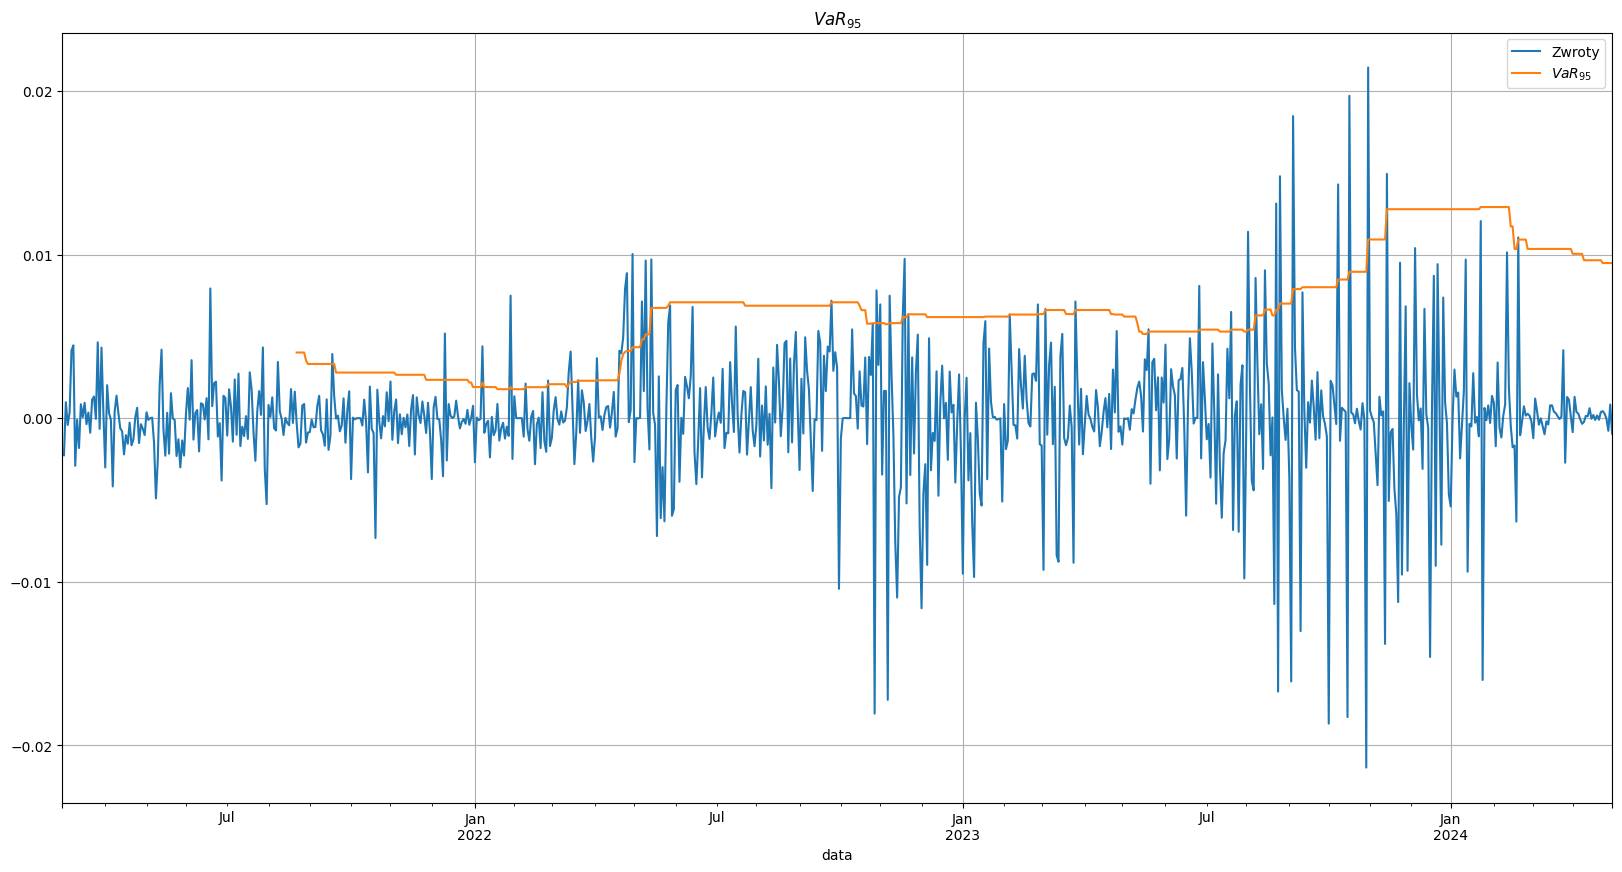

In [41]:
fig, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_hist']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$')
plt.legend(['Zwroty', '$VaR_{95}$'])
plt.savefig(f"pics\\{params['name']}\\var95.png")

Wykres cen i VaR95 dla cen.

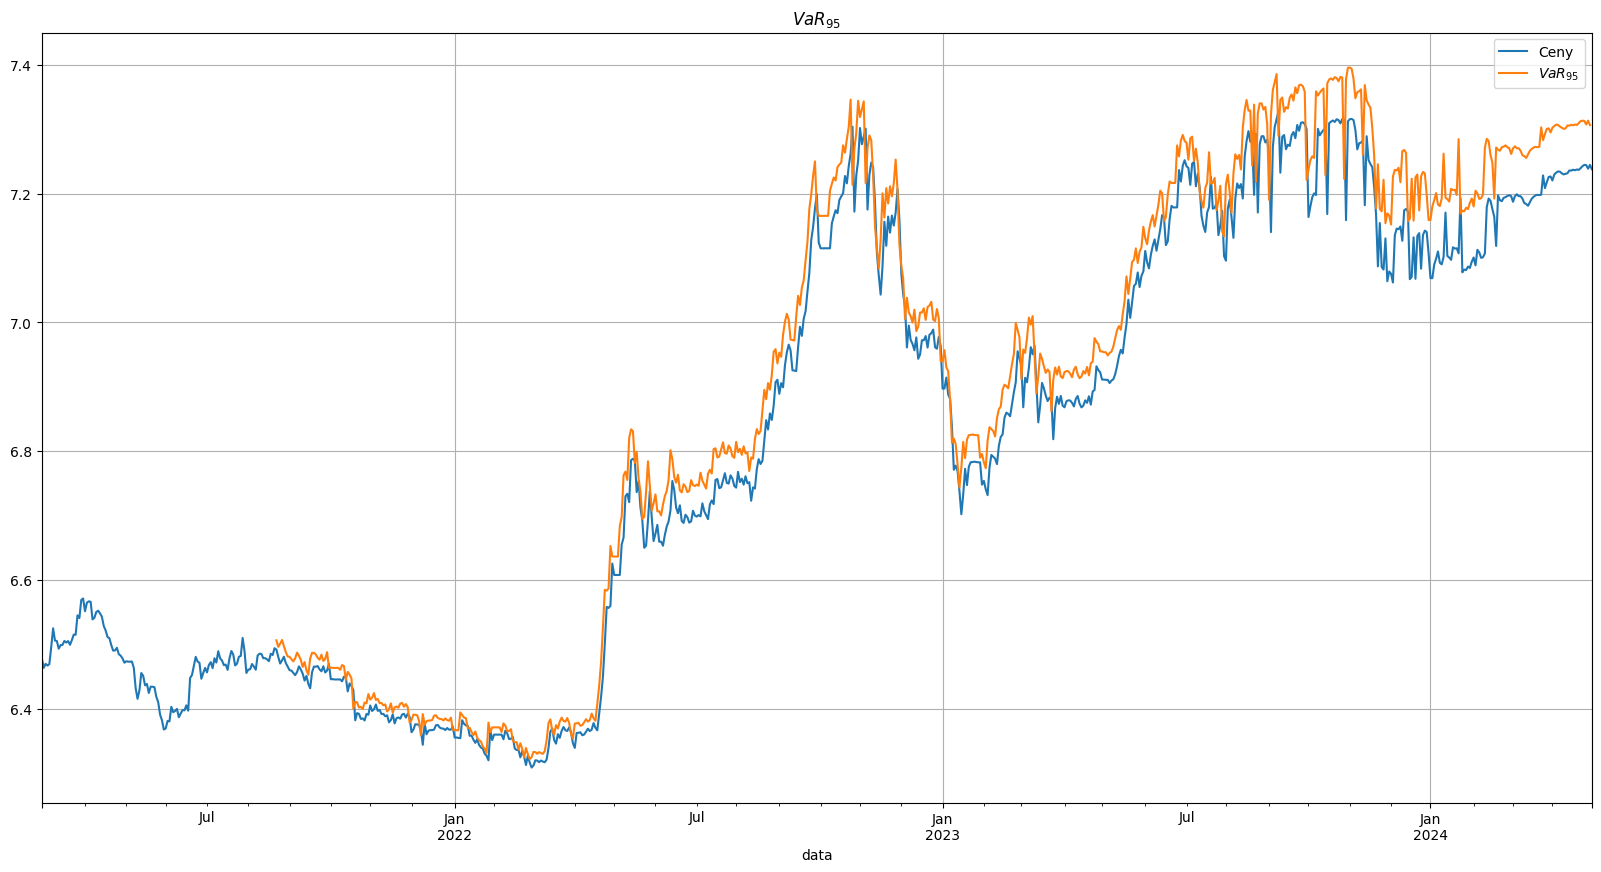

In [42]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['Close', 'VaR95_hist']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$')
plt.legend(['Ceny', '$VaR_{95}$'])
plt.savefig(f"pics\\{params['name']}\\var95_ceny.png")

In [43]:
data, I = exceeds_vector(data, 'hist')

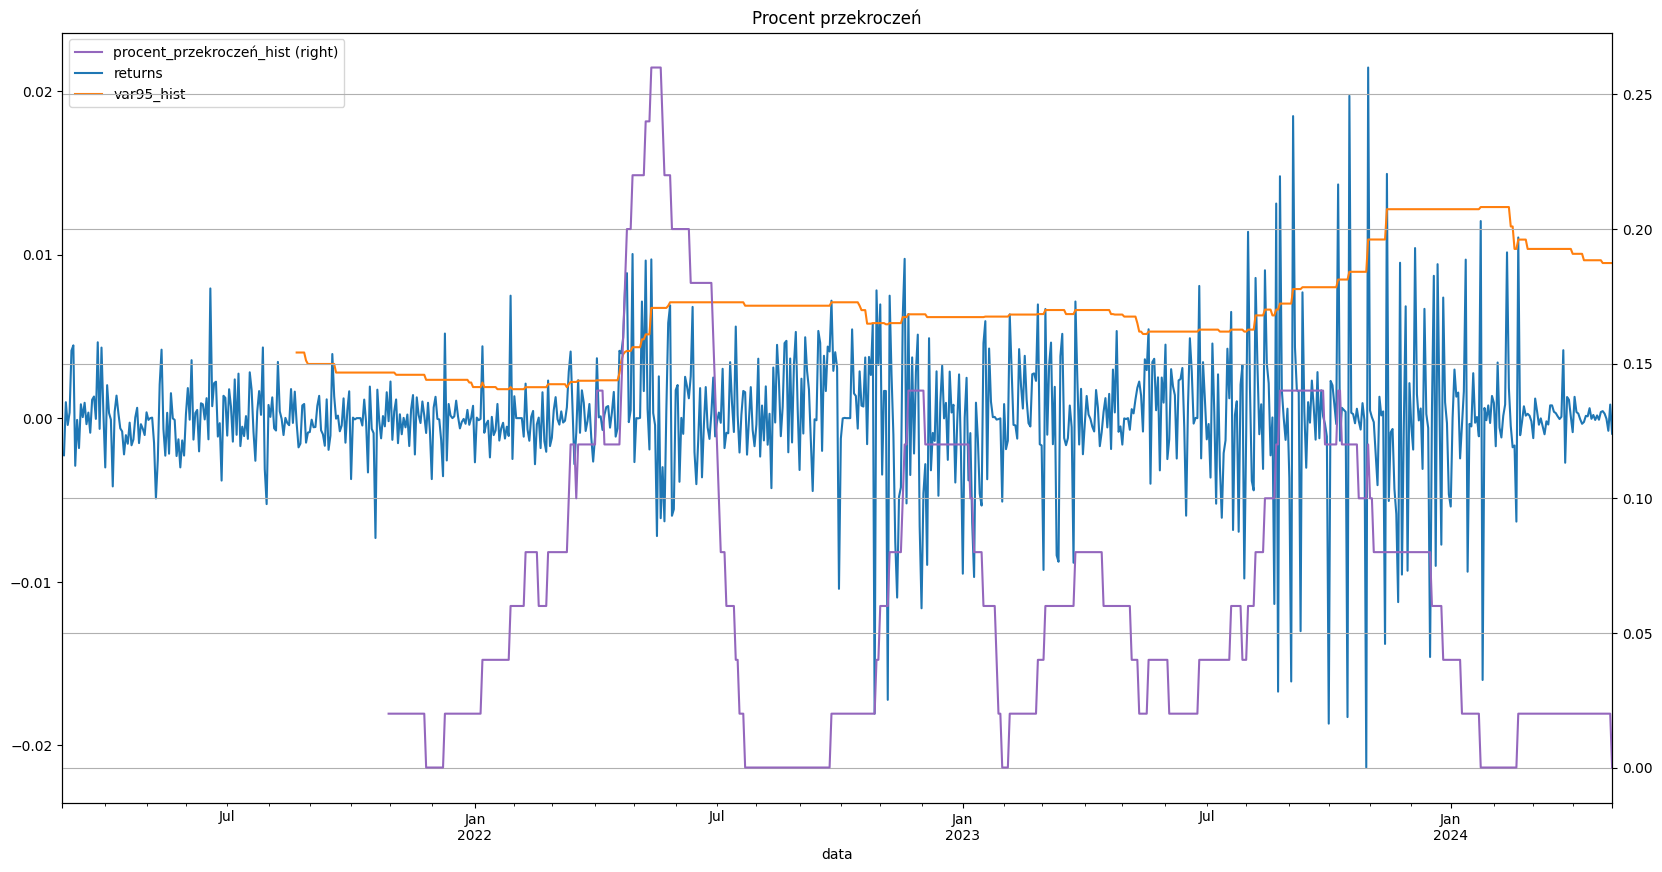

In [44]:
_, ax = plt.subplots(figsize=(20,10))
line1 = data[['procent_przekroczeń_hist']].plot(secondary_y=True,
                                            ax=ax,
                                            color='C4',
                                            legend=True)

_ = data[['returns', 'var95_hist']].plot(ax=ax,
                                         grid=True,
                                         style=['-', '-'],
                                         color=['C0', 'C1'],
                                         xlabel='data',
                                         title='Procent przekroczeń', legend=True)
plt.savefig(f"pics\\{params['name']}\\procent-var95.png")

## Testowanie wsteczne

### Rozkład dwumianowy

In [45]:
print('Średnia z przekroczeń = {}, 1 - {} = {}.\nWariancja z przekroczeń = {}, {}(1 - {}) = {}.'.\
    format(*map(lambda x: np.round(x, 3),
                [I.mean(), alpha, 1- alpha,
                 I.var(), alpha, alpha, alpha * (1 - alpha)])))

Średnia z przekroczeń = 0.066, 1 - 0.95 = 0.05.
Wariancja z przekroczeń = 0.062, 0.95(1 - 0.95) = 0.048.


In [46]:
stats.binomtest(int(I.sum()), n=I.size, p=1-alpha)

BinomTestResult(k=43, n=652, alternative='two-sided', statistic=0.06595092024539877, pvalue=0.07138320349790776)

# Metoda ważonej symulacji historycznej

In [47]:
lam = params['lambda']
alpha = 0.95

In [48]:
data = calculate_var(data, weighted_var, 'ważona')

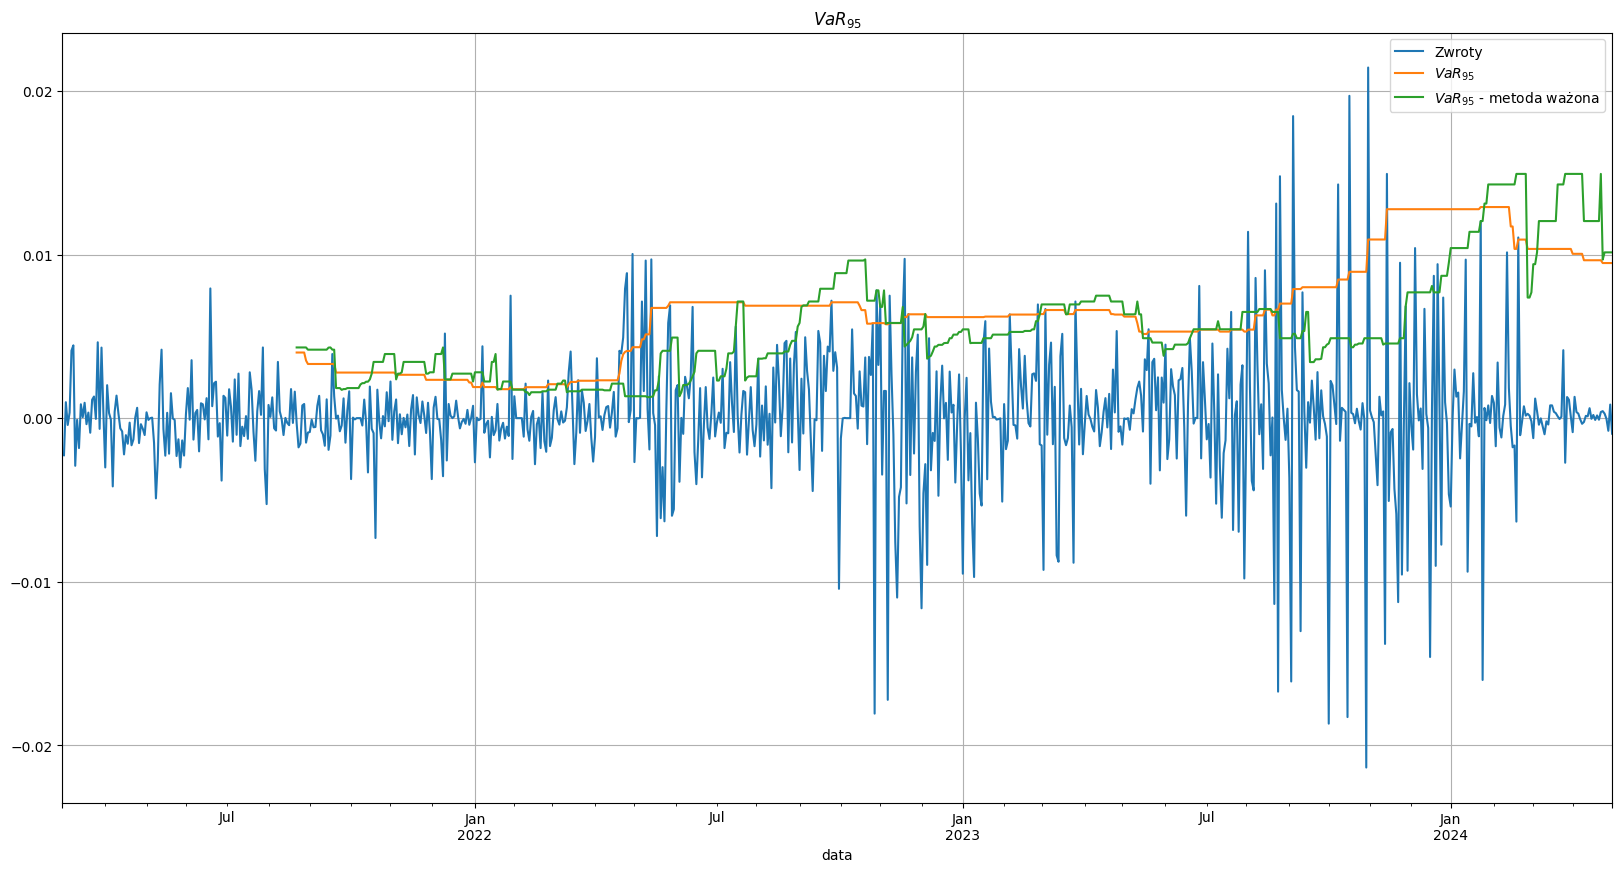

In [49]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_hist','var95_ważona']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$',
         color=['C0', 'C1', 'C2'])
plt.legend(['Zwroty', '$VaR_{95}$', '$VaR_{95}$ - metoda ważona'])
plt.savefig(f'pics\\{params["name"]}\\var95_wazony.png')

In [50]:
data, I_weighted = exceeds_vector(data, 'ważona')

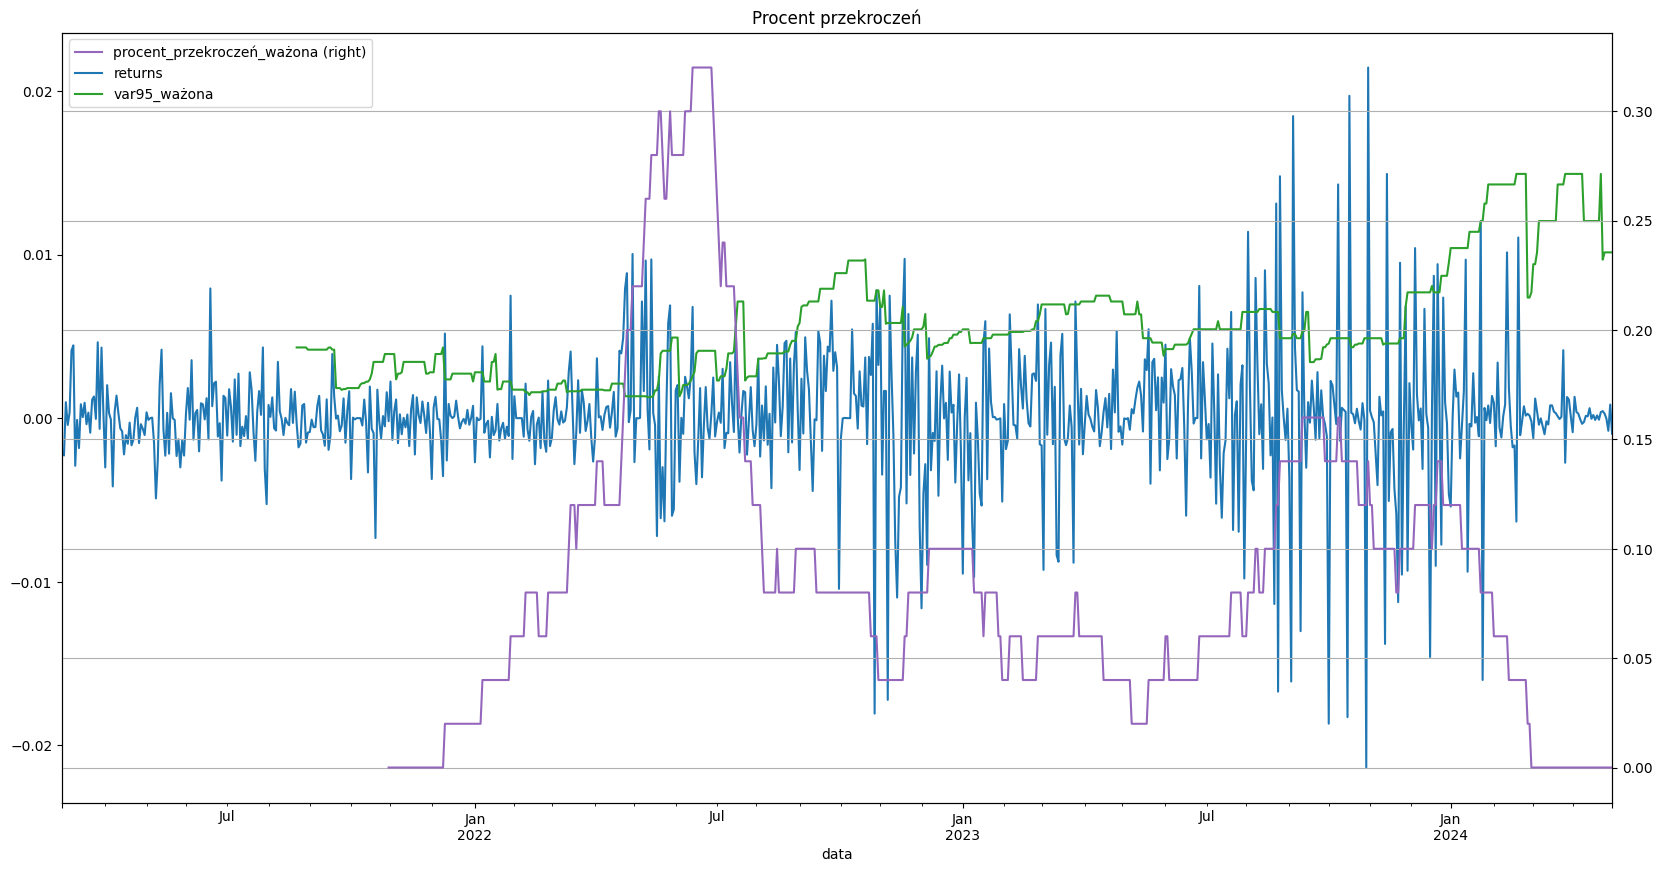

In [51]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['procent_przekroczeń_ważona']].plot(secondary_y=True,
                                            ax=ax,
                                            color='C4',
                                            legend=True)

_ = data[['returns', 'var95_ważona']].plot(ax=ax,
                                         grid=True,
                                         style=['-', '-'],
                                         color=['C0', 'C2'],
                                         xlabel='data',
                                         title='Procent przekroczeń', legend=True)
plt.savefig(f"pics\\{params['name']}\\procent-var95-ważona.png")

## Testowanie wsteczne

### Rozkład dwumianowy

In [52]:
print('Średnia z przekroczeń = {}, 1 - {} = {}.\nWariancja z przekroczeń = {}, {}(1 - {}) = {}.'. \
      format(*map(lambda x: np.round(x, 3),
                  [I_weighted.mean(), alpha, 1 - alpha,
                   I_weighted.var(), alpha, alpha, alpha * (1 - alpha)])))

Średnia z przekroczeń = 0.089, 1 - 0.95 = 0.05.
Wariancja z przekroczeń = 0.081, 0.95(1 - 0.95) = 0.048.


In [53]:
stats.binomtest(int(I_weighted.sum()), n=I_weighted.size, p=1-alpha)

BinomTestResult(k=58, n=652, alternative='two-sided', statistic=0.08895705521472393, pvalue=3.0021316960333444e-05)

# Metoda filtrowanej symulacji historycznej

In [54]:
%%capture
data = calculate_var(data, garch_var, 'garch')

In [55]:
data, I_garch = exceeds_vector(data, 'garch')

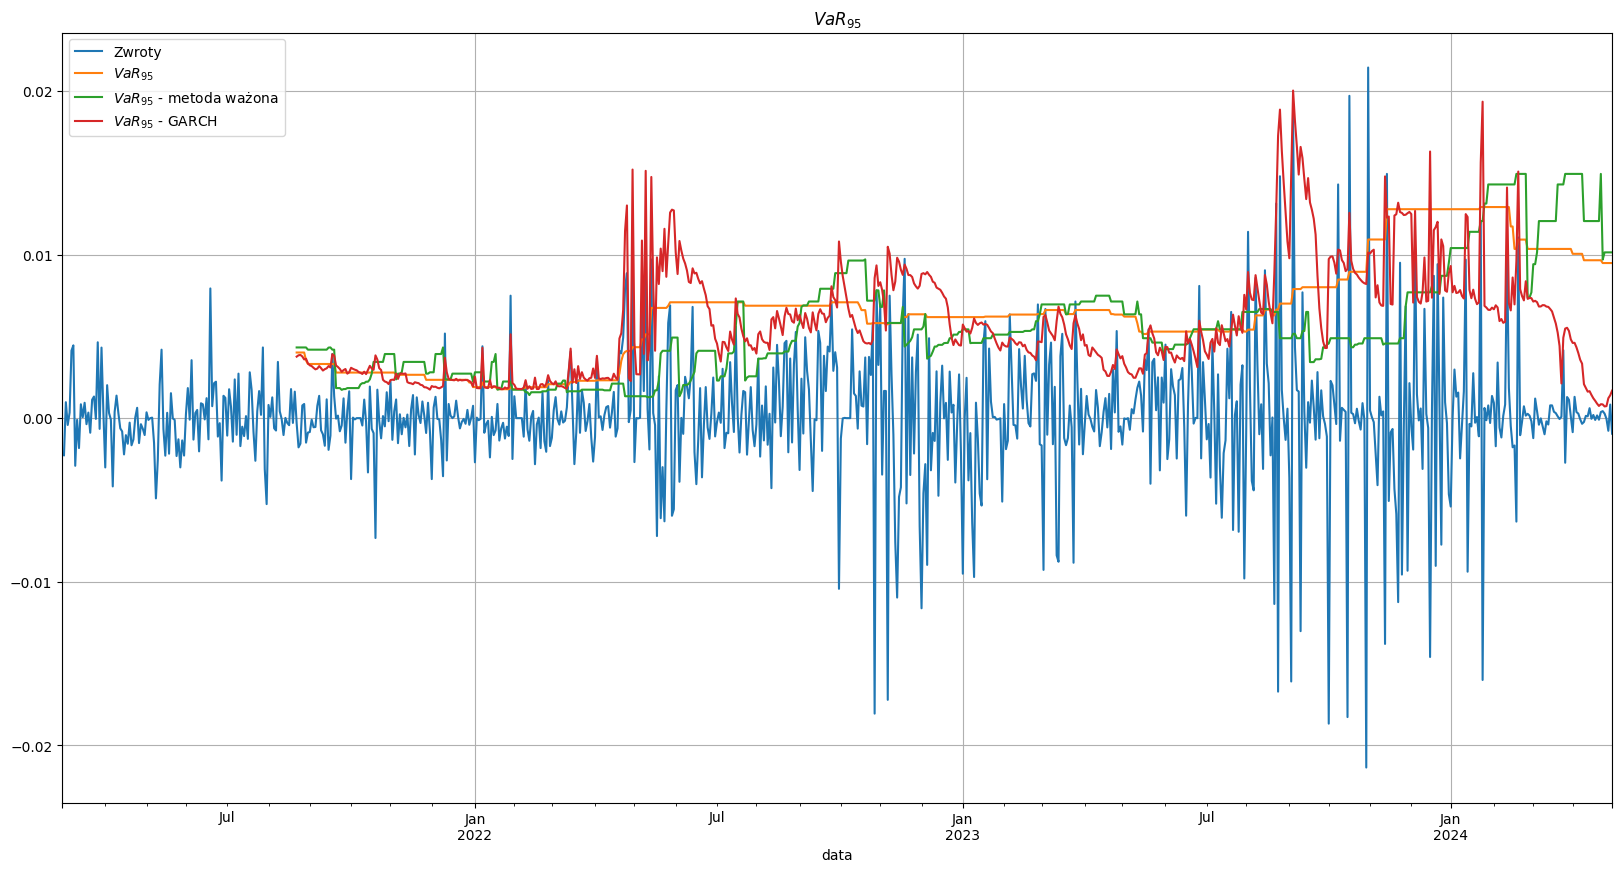

In [56]:
_, ax = plt.subplots(figsize=(20, 10))
_ = data[['returns', 'var95_hist', 'var95_ważona', 'var95_garch']].plot(ax=ax,
                                                                         grid=True,
                                                                         xlabel='data',
                                                                         title='$VaR_{95}$',
                                                                         color=['C0', 'C1', 'C2', 'C3'])
plt.legend(['Zwroty', '$VaR_{95}$', '$VaR_{95}$ - metoda ważona', '$VaR_{95}$ - GARCH'])
plt.savefig(f'pics\\{params["name"]}\\var95_garch.png')

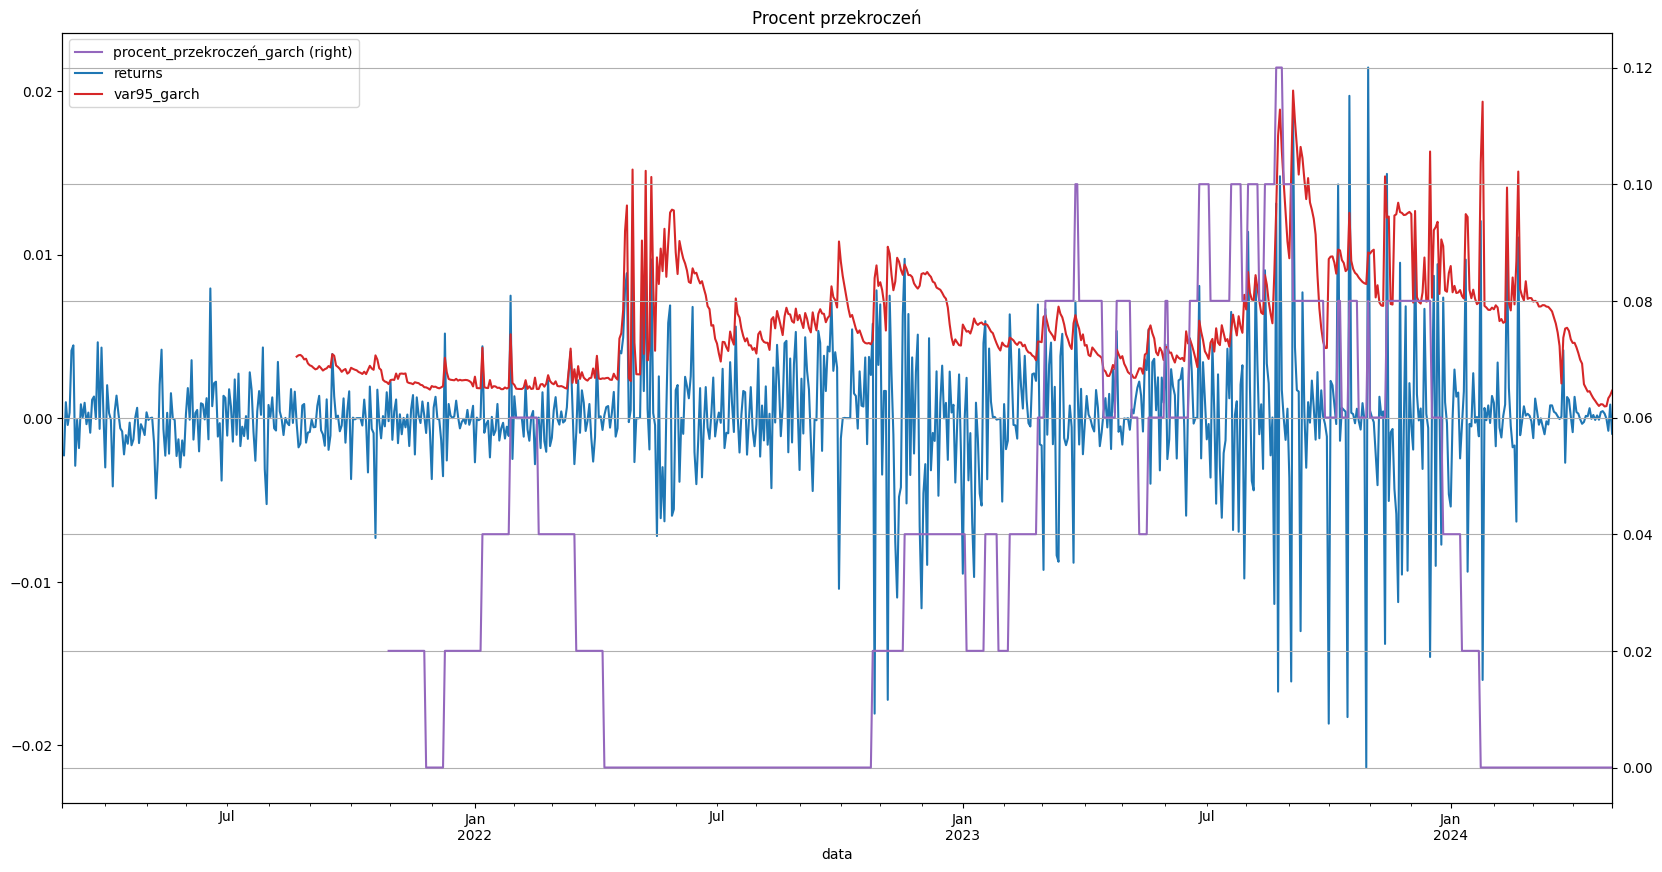

In [57]:
_, ax = plt.subplots(figsize=(20,10))
line1 = data[['procent_przekroczeń_garch']].plot(secondary_y=True,
                                            ax=ax,
                                            color='C4',
                                            legend=True)

_ = data[['returns', 'var95_garch']].plot(ax=ax,
                                         grid=True,
                                         style=['-', '-'],
                                         color=['C0', 'C3'],
                                         xlabel='data',
                                         title='Procent przekroczeń', legend=True)
plt.savefig(f"pics\\{params['name']}\\procent-var95-garch.png")

## Testowanie wsteczne

### Rozkład dwumianowy

In [58]:
print('Średnia z przekroczeń = {}, 1 - {} = {}.\nWariancja z przekroczeń = {}, {}(1 - {}) = {}.'. \
      format(*map(lambda x: np.round(x, 3),
                  [I_garch.mean(), alpha, 1 - alpha,
                   I_garch.var(), alpha, alpha, alpha * (1 - alpha)])))

Średnia z przekroczeń = 0.035, 1 - 0.95 = 0.05.
Wariancja z przekroczeń = 0.034, 0.95(1 - 0.95) = 0.048.


In [59]:
stats.binomtest(int(I_garch.sum()), n=I_garch.size, p=1-alpha)

BinomTestResult(k=23, n=652, alternative='two-sided', statistic=0.0352760736196319, pvalue=0.08757008516172445)